In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import diags

sns.set_context('paper')
sns.set_style('darkgrid')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

**Setting Initial Conditions for Wall Accelerating to U at *t*=0, C=0.1**

In [2]:
y_min = 0.0
y_max = 1.0

u_min = 0.0
u_max = 1.0

t_min = 0.0
t_max = 2.0

y_step = 0.1
t_step = 0.001

y_array = np.arange(y_min, y_max+y_step, y_step)
t_array = np.arange(t_min, t_max+t_step, t_step)
y_spacing = len(y_array)
t_spacing = len(t_array)
u_grid = np.zeros((y_spacing, t_spacing))

#Setting Initial Conditions
u_grid[0, :] = u_max

Note that we solve the implicit Crank-Nicolson scheme by solving the triagonal matrix.

In [3]:
def diffusion_Crank_Nicolson(dy,ny,dt,nt,v,V):
    V0 = V[0,:]
    V1 = V[-1,:]
    s = v*dt/dy**2
    A = diags([-0.5*s, 1+s, -0.5*s], [-1, 0, 1], 
          shape=(ny-2, ny-2)).toarray() 
    B1 = diags([0.5*s, 1-s, 0.5*s],[-1, 0, 1], shape=(ny-2, ny-2)).toarray()
    for n in range(1,nt): # time is going from second time step to last
        B = np.dot(V[1:-1, n-1],B1)
        B[0] = B[0]+s*(V0[n])
        B[-1] = B[-1]+s*(V1[n])
        V[1:-1,n] = np.linalg.solve(A,B)
    return np.copy(V)

def integrate_t(u_grid, method_func, t_array, y_step, t_step=t_step, v=1.0):
    u_grid_new = np.copy(u_grid)
    c = v*t_step/(y_step**2.0)
    if method_func != "crank_nicolson":
        for j in range(0,(np.shape(u_grid_new)[1]-1)):
            for i in range(1,(np.shape(u_grid_new)[0]-1)):
                u_grid_new[i,j+1] = c*(u_grid_new[i+1,j] + u_grid_new[i-1,j])+(1.0-2.0*c)*u_grid_new[i,j]
    else:
        u_grid_new = diffusion_Crank_Nicolson(y_step, np.shape(u_grid_new)[0],
                                              t_step, np.shape(u_grid_new)[1], v=v, V=u_grid_new)
    return u_grid_new

In [4]:
u_grid_euler = integrate_t(u_grid, "forward_euler", t_array, y_step)
u_grid_crank = integrate_t(u_grid, "crank_nicolson", t_array, y_step)
u_grid_euler_049 = integrate_t(u_grid, "forward_euler", t_array, y_step, v=4.9)
u_grid_crank_049 = integrate_t(u_grid, "crank_nicolson", t_array, y_step, v=4.9)
u_grid_euler_051 = integrate_t(u_grid, "forward_euler", t_array, y_step, v=5.1)
u_grid_crank_051 = integrate_t(u_grid, "crank_nicolson", t_array, y_step, v=5.1)
u_grid_euler_055 = integrate_t(u_grid, "forward_euler", t_array, y_step, v=5.5)
u_grid_crank_055 = integrate_t(u_grid, "crank_nicolson", t_array, y_step, v=5.5)


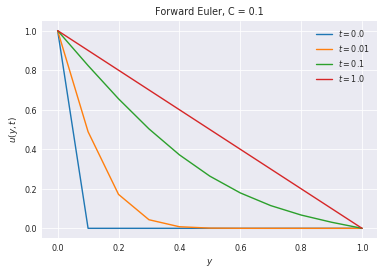

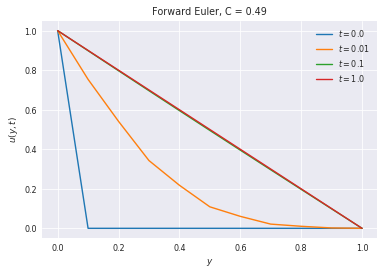

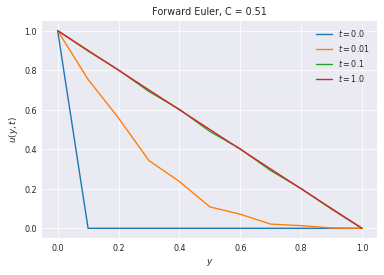

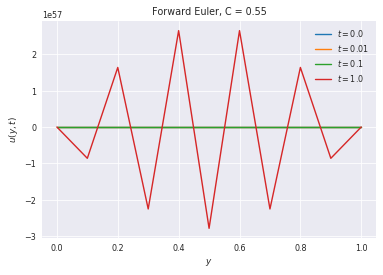

In [5]:
plt.plot(y_array, u_grid_euler[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_euler[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_euler[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_euler[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.title('Forward Euler, C = 0.1')
plt.legend()
plt.show()

plt.plot(y_array, u_grid_euler_049[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_euler_049[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_euler_049[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_euler_049[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.title('Forward Euler, C = 0.49')
plt.legend()
plt.show()

plt.plot(y_array, u_grid_euler_051[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_euler_051[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_euler_051[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_euler_051[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.title('Forward Euler, C = 0.51')
plt.legend()
plt.show()

plt.plot(y_array, u_grid_euler_055[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_euler_055[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_euler_055[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_euler_055[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.title('Forward Euler, C = 0.55')
plt.legend()
plt.show()

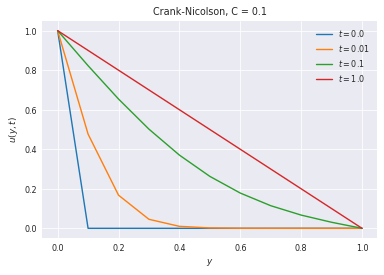

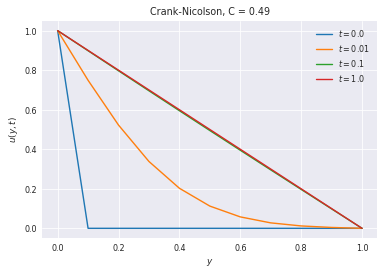

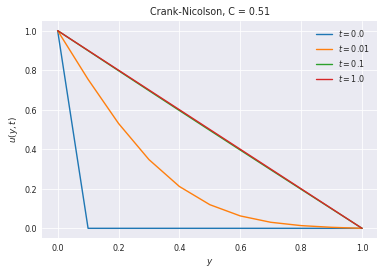

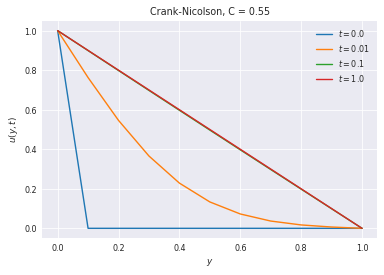

In [6]:
plt.title('Crank-Nicolson, C = 0.1')
plt.plot(y_array, u_grid_crank[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_crank[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_crank[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_crank[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.legend()
plt.show()

plt.title('Crank-Nicolson, C = 0.49')
plt.plot(y_array, u_grid_crank_049[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_crank_049[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_crank_049[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_crank_049[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.legend()
plt.show()

plt.title('Crank-Nicolson, C = 0.51')
plt.plot(y_array, u_grid_crank_051[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_crank_051[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_crank_051[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_crank_051[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.legend()
plt.show()

plt.title('Crank-Nicolson, C = 0.55')
plt.plot(y_array, u_grid_crank_055[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_crank_055[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_crank_055[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_crank_055[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.legend()
plt.show()

Here we see that the Crank-Nicolson scheme avoids blowing up for $C > 0.5$. Increasing $C$ allows the linear flow to be achieved quicker (the $t=0.1$ lines are hidden under the $t=1$ lines for the cases plotted where $C > 0.1$). $C$ relates to the speed of diffusion so this makes sense intuitively.

**Implementing an Oscillating Boundary**

In [7]:
y_min = 0.0
y_max = 10.0

t_min = 0.0
t_max = 2.0*np.pi

y_step = 0.05
t_step = 0.0005

y_osc = np.arange(y_min, y_max+y_step, y_step)
t_osc = np.arange(t_min, t_max+t_step, t_step)
y_osc_spacing = len(y_osc)
t_osc_spacing = len(t_osc)
u_grid_osc = np.zeros((y_osc_spacing, t_osc_spacing))
u_grid_osc_2 = np.zeros((y_osc_spacing, t_osc_spacing))

#Setting Initial Conditions
omega = 1.0
u_grid_osc[0, :] = np.cos(omega*t_osc)
u_grid_osc = integrate_t(u_grid_osc, "crank_nicolson", t_osc, y_step, t_step=t_step)

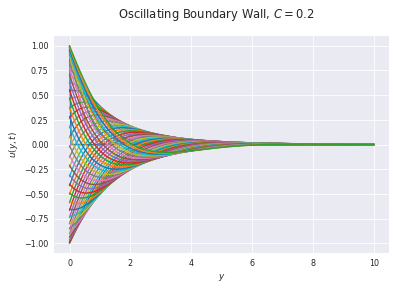

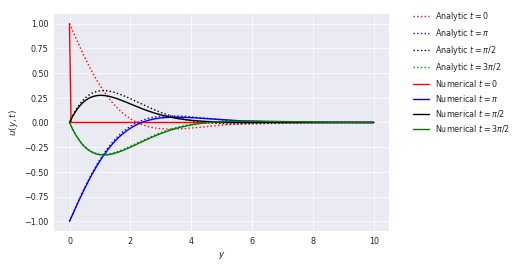

In [8]:
for i in range(0, len(t_osc), 200):
    plt.plot(y_osc, u_grid_osc[:, i], label=r'$t=$' + str(t_osc[i]))
plt.xlabel(r'$y$')
plt.ylabel(r'$u(y, t)$')
plt.suptitle(r'Oscillating Boundary Wall, $C = 0.2$')
#plt.legend()
plt.show()

factor = y_osc*np.sqrt(omega/(2.0))
analytic_u_t_0_pi_1 = np.exp(-factor)*np.cos(-factor)
analytic_u_t_1_pi_2 = np.exp(-factor)*np.cos(0.5*np.pi - factor)
analytic_u_t_1_pi_1 = np.exp(-factor)*np.cos(np.pi - factor)
analytic_u_t_3_pi_2 = np.exp(-factor)*np.cos(1.5*np.pi - factor)
integrated_u_t_0_pi_1 = u_grid_osc[:, 0]
integrated_u_t_1_pi_2 = u_grid_osc[:, int(0.5*np.pi/t_step)]
integrated_u_t_1_pi_1 = u_grid_osc[:, int(np.pi/t_step)]
integrated_u_t_3_pi_2 = u_grid_osc[:, int(1.5*np.pi/t_step)]

plt.plot(y_osc, analytic_u_t_0_pi_1, ':r', label='Analytic $t=0$')
plt.plot(y_osc, analytic_u_t_1_pi_1, ':b', label='Analytic $t=\pi$')
plt.plot(y_osc, analytic_u_t_1_pi_2, ':k', label='Analytic $t=\pi/2$')
plt.plot(y_osc, analytic_u_t_3_pi_2, ':g', label='Analytic $t=3\pi/2$')

plt.plot(y_osc, integrated_u_t_0_pi_1, '-r', label='Numerical $t=0$')
plt.plot(y_osc, integrated_u_t_1_pi_1, '-b', label='Numerical $t=\pi$')
plt.plot(y_osc, integrated_u_t_1_pi_2, '-k', label='Numerical $t=\pi/2$')
plt.plot(y_osc, integrated_u_t_3_pi_2, '-g', label='Numerical $t=3\pi/2$')
plt.gca().legend(bbox_to_anchor=(1.05, 1.05))
plt.xlabel('$y$')
plt.ylabel(r'$u(y, t)$')
plt.show()


The analytic solution is given by: $u(y, t) = U e^{-y\sqrt{\omega/2v}} \cos{\left(\omega t - y \sqrt{\frac{\omega}{2v}}\right)}$ and while the numerical solution does not match it at $t=0$ (impossible given our initial conditions), it converges to the analytic solution by $t = \frac{3\pi}{2}$ fairly closely.